In [40]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

%matplotlib inline

In [7]:
url = "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/ESS_practice_data/ESSdata_Thinkful.csv"
df = pd.read_csv(url).dropna()
print(df.shape)
df.head()

(8147, 13)


,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


In [3]:
X = df.loc[:, ~ df.columns.isin(["partner", "cntry", "idno"])]
y = df["partner"] - 1
X = pd.concat([X, pd.get_dummies(df["cntry"])], axis=1)

In [21]:
# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [22]:
params = {"n_estimators": 500,
         "max_depth": 2,
         "loss": "deviance"}

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [25]:
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [26]:
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

In [27]:
table_train

col_0,0.0,1.0,All
partner,,,
0.0,4167,341,4508
1.0,1291,1533,2824
All,5458,1874,7332


In [30]:
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

In [31]:
print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


In [36]:
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)
print("Train score: ", train_score)
print("Test score: ", test_score)

Train score:  0.7774140752864157
Test score:  0.7521472392638037


In [37]:
clf.feature_importances_

array([0.01497972, 0.08383276, 0.08240387, 0.07755603, 0.05077273,
       0.1561715 , 0.04937317, 0.03993169, 0.05944413, 0.27496302,
       0.01505447, 0.01558719, 0.00600491, 0.03773901, 0.02324548,
       0.01294032])

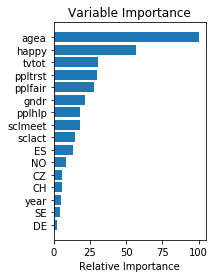

In [38]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Challenge starts here...
Model tuning

In [58]:
param_grid = {"gb__n_estimators": [250, 500, 800, 1000],
         "gb__max_depth": [1, 2, 3, 4, 5],
         "gb__loss": ["deviance", "exponential"]}

start_time = time.time()
gb_pipe = Pipeline([("gb", ensemble.GradientBoostingClassifier())])
gs = GridSearchCV(estimator=gb_pipe,
                 param_grid=param_grid,
                 scoring="accuracy",
                 cv=5,
                 n_jobs=-1)
gs.fit(X_train, y_train)
total_time = time.time() - start_time
print(gs.best_score_)
print(gs.best_params_)
print("----- {:.6f} -----".format(total_time))

0.6921713038734315
{'gb__loss': 'deviance', 'gb__max_depth': 1, 'gb__n_estimators': 250}
----- 122.738455 -----


I actually don't understand this result. It should have at least matched the accuracy from the guided example.

Try without the country variables, which don't look that important.

In [88]:
X = df.loc[:, ~ df.columns.isin(["partner", "cntry", "idno"])]

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [60]:
param_grid = {"gb__n_estimators": [250, 500, 800, 1000],
         "gb__max_depth": [1, 2, 3, 4, 5],
         "gb__loss": ["deviance", "exponential"]}

start_time = time.time()
gb_pipe = Pipeline([("gb", ensemble.GradientBoostingClassifier())])
gs = GridSearchCV(estimator=gb_pipe,
                 param_grid=param_grid,
                 scoring="accuracy",
                 cv=5,
                 n_jobs=-1)
gs.fit(X_train, y_train)
total_time = time.time() - start_time
print(gs.best_score_)
print(gs.best_params_)
print("----- {:.6f} -----".format(total_time))

0.752454991816694
{'gb__loss': 'deviance', 'gb__max_depth': 2, 'gb__n_estimators': 250}
----- 96.092785 -----


In [62]:
gb_best = gs.best_estimator_
train_pred = gb_best.predict(X_train)

from sklearn.metrics import confusion_matrix
confu_mat = confusion_matrix(y_train, train_pred)
confu_mat

array([[4166,  342],
       [1341, 1483]], dtype=int64)

Now it's only a little worse than the guided example model.

Try scaling the variables.

In [63]:
from sklearn.preprocessing import StandardScaler
param_grid = {"gb__n_estimators": [250, 500, 800, 1000],
         "gb__max_depth": [1, 2, 3, 4, 5],
         "gb__loss": ["deviance", "exponential"]}

start_time = time.time()
gb_pipe = Pipeline([("scl", StandardScaler()),
                    ("gb", ensemble.GradientBoostingClassifier())])
gs = GridSearchCV(estimator=gb_pipe,
                 param_grid=param_grid,
                 scoring="accuracy",
                 cv=5,
                 n_jobs=-1)
gs.fit(X_train, y_train)
total_time = time.time() - start_time
print(gs.best_score_)
print(gs.best_params_)
print("----- {:.6f} -----".format(total_time))

0.752454991816694
{'gb__loss': 'deviance', 'gb__max_depth': 2, 'gb__n_estimators': 250}
----- 98.983413 -----


That did nothing.

Try AdaBoostClassifier with a decision tree.

In [69]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid = {"dt__criterion": ["gini", "entropy"],
              "dt__max_depth": [1, 2, 3, 4, 5, None],
              "dt__max_features": [1, 2, 3, None]}

# Tune the tree
start_time = time.time()
dt_pipe = Pipeline([("dt", DecisionTreeClassifier())])
gs = GridSearchCV(estimator=dt_pipe,
                 param_grid=param_grid,
                 scoring="accuracy",
                 cv=5,
                 n_jobs=-1)
gs.fit(X_train, y_train)
total_time = time.time() - start_time
print(gs.best_score_)
print(gs.best_params_)
print("----- {:.6f} -----".format(total_time))

0.7412711402073104
{'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__max_features': None}
----- 6.380602 -----


In [70]:
dt_best = gs.best_estimator_
train_pred = dt_best.predict(X_train)

confu_mat = confusion_matrix(y_train, train_pred)
confu_mat

array([[4203,  305],
       [1485, 1339]], dtype=int64)

Slight improvment in Type I errors from just the decsion tree model. Type II is worse.

In [91]:
# Put the tuned tree into the AdaBoostClassifier
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5, max_features=None)
dt.fit(X_train, y_train)

#dt_best.fit(X_train, y_train)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=500)
ada.fit(X_train, y_train)
train_score = ada.score(X_train, y_train)
print("Train score: ", train_score)

Train score:  1.0


Hmmm?

In [90]:
test_score = ada.score(X_test, y_test)
print("Test score: ", test_score)

Test score:  0.6687116564417178


In [95]:
test_pred = ada.predict(X_test)

confu_mat = confusion_matrix(y_test, test_pred)
confu_mat

array([[395, 110],
       [145, 165]], dtype=int64)

In [98]:
print("Type I Error {}\nType II Error {}".format((confu_mat[0,1]/np.sum(confu_mat)),
                                                 (confu_mat[1,0]/np.sum(confu_mat))))

Type I Error 0.13496932515337423
Type II Error 0.17791411042944785


Not really any better. I'm stumped.